# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [20]:
# import libraries
import pandas as pd
import numpy as np


from sqlalchemy import create_engine

import datetime
import json
import re

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntProgress
from IPython.display import display
from IPython.display import Image
from IPython.core.display import HTML



from matplotlib import pyplot as plt

In [21]:
# load messages dataset
messages = pd.read_csv("./messages.csv")
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [22]:
# load categories dataset
categories = pd.read_csv("./categories.csv")
categories_id = categories["id"]
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [23]:
# merge datasets
df = messages.join(categories.set_index('id'), on='id')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [24]:
# create a dataframe of the 36 individual category columns
categories = categories["categories"].str.split(";",expand=True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [25]:
# select the first row of the categories dataframe
row = categories.loc[:0]

# use this row to extract a list of new column names for categories.
# one way is to apply a lambda function that takes everything 
# up to the second to last character of each string with slicing
category_colnames = row.apply(lambda x: x.str[0:-2], axis=0)
print(category_colnames.values)

[['related' 'request' 'offer' 'aid_related' 'medical_help'
  'medical_products' 'search_and_rescue' 'security' 'military'
  'child_alone' 'water' 'food' 'shelter' 'clothing' 'money'
  'missing_people' 'refugees' 'death' 'other_aid'
  'infrastructure_related' 'transport' 'buildings' 'electricity' 'tools'
  'hospitals' 'shops' 'aid_centers' 'other_infrastructure'
  'weather_related' 'floods' 'storm' 'fire' 'earthquake' 'cold'
  'other_weather' 'direct_report']]


In [26]:
# rename the columns of `categories`
categories.columns = category_colnames.values[0]
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [27]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].apply(lambda x: x[-1])
    
    # convert column from string to numeric
    categories[column] = categories[column].astype('int32')
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [28]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories], axis=1)
df.drop(columns=['categories'],inplace=True)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [29]:
# check number of duplicates
df.duplicated().sum()

170

In [30]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [31]:
# check number of duplicates
df.duplicated().sum()

0

### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [32]:
engine = create_engine('sqlite:///etl_pipeline.db')
df.to_sql('etl_pipeline', engine, index=False)

### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.

<AxesSubplot:ylabel='genre,None'>

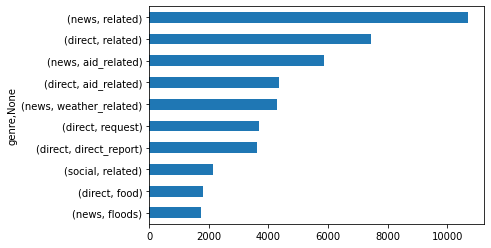

In [107]:
df[df["genre"] == "direct"].iloc[:,1:].groupby("genre").sum().stack().sort_values(ascending=False).head(10).plot.barh()

In [68]:
df.groupby("genre").sum()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
genre,,,,,,,,,,,,,,,,,,,,,
direct,67036635,7446,3696,46,4338,592,471,216,131,46,...,78,186,1521,304,315,41,796,63,207,3613
news,299791191,10707,604,65,5860,1415,793,441,292,801,...,218,866,4280,1747,1445,225,910,415,1052,852
social,32306090,2129,174,7,662,77,49,67,48,13,...,13,99,1496,104,683,16,749,52,117,610


<AxesSubplot:ylabel='id'>

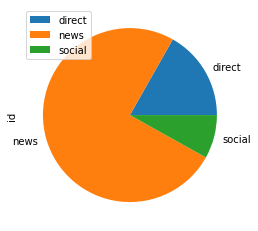

In [70]:
df.groupby("genre").sum().plot.pie(y='id')

<AxesSubplot:ylabel='genre'>

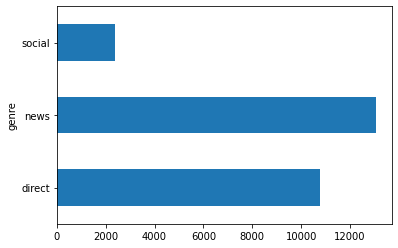

In [74]:
df.groupby('genre').count()['message'].plot.barh(x='genre', y='id')

In [143]:
df[df["genre"] == "direct"].iloc[:,1:].groupby("genre").sum().index

Index(['direct'], dtype='object', name='genre')

In [159]:
df[df["genre"] == "direct"].iloc[:,1:].groupby("genre").sum().stack().sort_values().reset_index().drop(columns="genre").tail(10)

,level_1,0
26,earthquake,796
27,water,836
28,shelter,1152
29,weather_related,1521
30,other_aid,1575
31,food,1807
32,direct_report,3613
33,request,3696
34,aid_related,4338
35,related,7446


In [133]:
genre_top10 = df[df["genre"] == "direct"].iloc[:,1:].groupby("genre").sum().reset_index().stack().sort_values().tail(10)

TypeError: '<' not supported between instances of 'int' and 'str'

In [126]:
genre_top10.index

MultiIndex([('direct',      'earthquake'),
            ('direct',           'water'),
            ('direct',         'shelter'),
            ('direct', 'weather_related'),
            ('direct',       'other_aid'),
            ('direct',            'food'),
            ('direct',   'direct_report'),
            ('direct',         'request'),
            ('direct',     'aid_related'),
            ('direct',         'related')],
           names=['genre', None])

<AxesSubplot:ylabel='genre,None'>

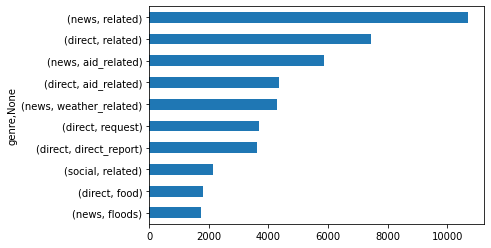

In [113]:
genre_top10.plot.barh()

In [120]:
list(genre_top10.index)

[('news', 'floods'),
 ('direct', 'food'),
 ('social', 'related'),
 ('direct', 'direct_report'),
 ('direct', 'request'),
 ('news', 'weather_related'),
 ('direct', 'aid_related'),
 ('news', 'aid_related'),
 ('direct', 'related'),
 ('news', 'related')]